In [1]:
import sys
sys.path.append("..")
from data_loader import *
from model import *
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

import skimage
from skimage.morphology import square, disk
from skimage import morphology
from skimage import measure

import torch.nn.functional as F
import numbers
from ssim_loss import *
import models
from models import dist_model as dm

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:

def min_max_norm(image, top_perc=0):
    if top_perc == 0 :
        a_min = np.min(image.flatten())
        a_max = np.max(image.flatten())
    else:
        a_min = np.percentile(image.flatten(), q=top_perc)
        a_max = np.percentile(image.flatten(), q=100 - top_perc)
    
    
    return (image - a_min) / (a_max - a_min)
    

In [6]:

model = GeneratorClassConditional(c_dim=3, conv_dim = 32, norm="cbatch",topk=32, no_memory = False, z_dim=256, mem_dim=32, n_downsample=5, num_cls=1)


model.load_weights("checkpoints/2020-12-07 02_33_12.137990 wood_-1.0/weights/gen_mae_cls_005000.pth") # +- a few :P


if torch.cuda.is_available():
    model.cuda()

In [4]:
use_gpu = True         # Whether to use GPU
spatial = True         # Return a spatial map of perceptual distance.

# Linearly calibrated models (LPIPS)
lpips = models.PerceptualLoss(model='net-lin', net='squeeze', use_gpu=use_gpu, spatial=spatial)

# lpips2 = models.PerceptualLoss(model='net-lin', net='squeeze', use_gpu=use_gpu, spatial=False)

Setting up Perceptual loss...
Loading model from: D:\demo_memae\models\weights\v0.1\squeeze.pth
...[net-lin [squeeze]] initialized
...Done


In [21]:
class_subset = "wood"
batch_size = 8
data_mode = "val"
data_path = "E:/Datasets/MVTec"
data_loader = get_loader(data_path, dataset="MVTec", shot="all", image_size=[256,256,3],
                        mode=data_mode, augment=False, shuffle=False, batch_size=batch_size, num_workers=4, subset=class_subset, percent_defect=-1)
predictions = []
for j, (image, cls_, im_path,_) in enumerate(tqdm_notebook(data_loader)):
    image = image.cuda()
    model.eval()
    with torch.no_grad():
        rec,w,_,z,z_hat = model(image, cls_)
        
        lpips_err = lpips.forward(image,rec).squeeze(1)
    
        rec_err = torch.mean(torch.abs(rec - image)**2, dim=1)
        rec_err_avg = F.avg_pool2d(rec_err, kernel_size=7, stride=1, padding=3)
        
        error_map = lpips_err ** 2 * rec_err
        
        error_map_avg = lpips_err ** 2 * rec_err_avg
        
    
        for i in range(image.size(0)):
            is_defect = int("good" not in im_path[i])
            
            err_map = error_map[i].cpu().numpy()
            err_map_avg = error_map_avg[i].cpu().numpy()
        
            predictions.append([cls_[i].item(), is_defect, np.mean(err_map), np.max(err_map), np.mean(err_map_avg), np.max(err_map_avg), np.max(lpips_err[i].cpu().numpy()**2)])


KeyboardInterrupt: 

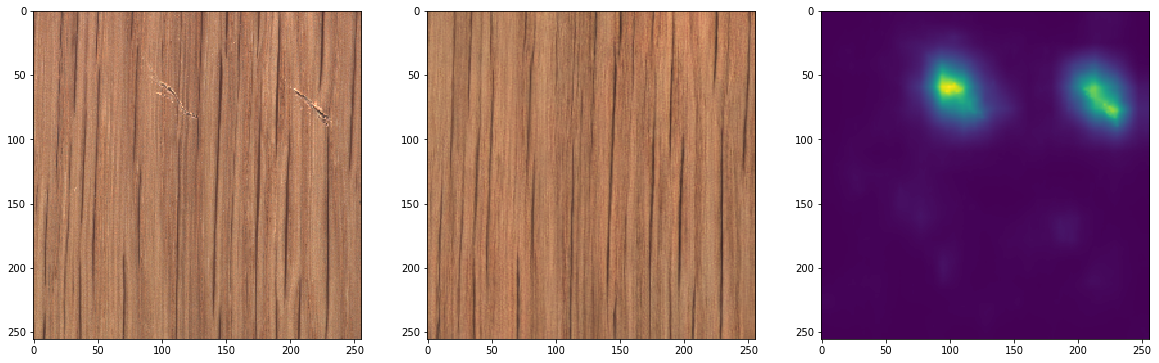

In [23]:
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow((image[1].cpu().permute(1,2,0)+1) / 2)
plt.subplot(132)
plt.imshow((rec[1].cpu().permute(1,2,0)+1) / 2)
plt.subplot(133)
plt.imshow(lpips_err[1].cpu()**2)